# 2.1 Bayesian Linear Regression

To get a better understanding of Gaussian Processes it makes sense to review _Bayesian Linear Regression_ by following the explanations and steps in the book _Gaussian Processes_ by Rasmussen, Chapter 2. First we'll start with the view in the weight-space and then extend this setting in the feature space view. From there we can switch to a function-space view in which we can show what a Gaussian Process is.

### Weight-Space View

We define a simple linear relationship between $x\in\mathbb{R}^D$ and $y\in\mathbb{R}$ with white noise (RM, 2.1, 2.2):

$$
f(x) = x^T \mathrm{w},\qquad  y = f(x) + \epsilon $$

$$\epsilon \sim \mathcal{N}(0,\sigma_{n}^2)$$

where $w\in\mathbb{R}^D$.

Let's shortly review the formula for the multivariate normal distribution:

$$
f(x) = 
    \frac{1}{\sqrt{(2\pi)^{D}|\Sigma|}}\exp\left( -\frac{1}{2} (x-\mu)^T\Sigma^{-1}(x-\mu) \right)
    \sim \mathcal{N}(\mu,\Sigma)
$$

Where $x\in\mathbb{R}^D$ is the realisation of a random variable, $\mu\in\mathbb{R}^D$ and $\Sigma\in\mathbb{R}^{D\times D}$ are the parameters which fully describe the multivariate normal.

In [1]:
import numpy as np
import matplotlib.pylab as plt

Let's create data with the relationship described above:

In [2]:
import numpy as np

# Define w_true
w_true = np.array([-0.5, 1]).reshape(-1, 1)

# Generate X with ones and linspace
x0 = np.ones(10).astype(float)  # Use built-in float
x1 = np.linspace(-5, 5, 10).astype(float)
X = np.vstack((x0, x1))


# Calculate f
f = np.dot(X.T, w_true)

# Add noise
sigma_n = 2.0
np.random.seed(5)
epsilon = np.random.normal(0, sigma_n, 10).reshape(-1, 1)

# Generate noisy observations y
y = f + epsilon


In [3]:
X.shape

(2, 10)

In [4]:
y.shape

(10, 1)

Text(0.5, 1.0, '-0.5 + x + epsilon = y = f(x)')

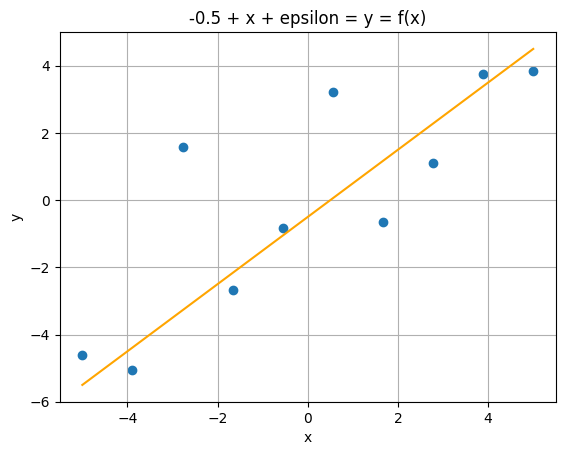

In [5]:
plt.scatter(x1,y)
plt.plot(x1,f,'orange')
plt.ylabel("y")
plt.xlabel("x")
plt.grid()
plt.title("-0.5 + x + epsilon = y = f(x)")

$X\in\mathbb{R}^{D\times N}$ is the _design matrix_ and $\mathrm{w}\in\mathbb{R}^D$ is the weight vector (parameters) of the linear model, $f$ is the function value and $y$ the observed response variable value.
For simplicity we add a row vector with ones to the input vector $X$.
This noise assumption together with the model gives rise to the likelihood, the probability of the observation given the parameter, which is factored over cases in the training set to give (RM, 2.3):

$$ \epsilon = f(x) - y \sim \mathcal{N}(0,\sigma_{n}^2)$$

$$
f(y \mid X, \mathrm{w}) = \prod_{i=1}^{n} P(y_i \mid \mathrm{x}_i, \mathrm{w})
= \prod_{i=1}^{n} \frac{1}{{\sqrt {2\pi } } \sigma_n} \exp\left(- \frac{(y_i - \mathrm{x}_i^T\mathrm{w})^2}{2\sigma_n^2}\right)
$$

$$ 
f(y \mid X, \mathrm{w}) = 
\frac{1}{\left(2\pi\sigma_n^2\right)^{n/2}} \exp\left(- \frac{1}{2\sigma_n^2}|y-X^T\mathrm{w}|^2\right)
= \mathcal{N}(X^T\mathrm{w},\sigma_{n}^2I)
$$

## Prior Distribution

In the Bayesian formalism
we need to specify a prior over the parameters, expressing our beliefs about the prior
parameters before we look at the observations. We put a zero mean Gaussian
prior with covariance matrix $\Sigma_p$ on the weights (RM,  2.4)

$$ \mathrm{w} \sim \mathcal{N}(0,\Sigma_{p})$$

In [6]:
Sigma_p = np.eye(X.shape[0]) * 1.0

Text(0.5, 1.0, 'Contourplot of Prior p(w)')

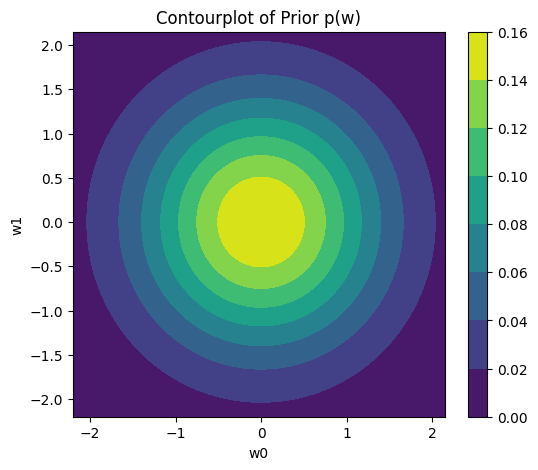

In [7]:
from scipy.stats import multivariate_normal
x12, y12 = np.mgrid[-2.2:2.2:.05, -2.2:2.2:.05]
pos = np.empty(x12.shape + (2,))
pos[:, :, 0] = x12; pos[:, :, 1] = y12
rv = multivariate_normal([0,0], Sigma_p)

fig, ax = plt.subplots(figsize=(6, 5))
h = ax.contourf(x12, y12, rv.pdf(pos))
fig.colorbar(h)
ax.set_ylabel("w1")
ax.set_xlabel("w0")
plt.title("Contourplot of Prior p(w)")

## Posterior Distribution

Inference in the Bayesian linear model is based on the posterior distribution
over the weights, computed by Bayes’ rule (RM, (2.5)):

$$
\text{posterior} = \frac{\text{likelihood x prior}}{\text{marginal likelihood}},\quad
f(\mathrm{w} \mid \mathrm{y}, X) = \frac{f(\mathrm{y} \mid X, \mathrm{w})f(\mathrm{w})}{f(\mathrm{y} \mid X)}
$$

Where the normalizing constant, also known as the marginal likelihood, is independet of the weights and given by (RM, 2.6)

$$
f(\mathrm{y} \mid X) = \int f(\mathrm{y} \mid X, \mathrm{w})f(\mathrm{w}) d\mathrm{w}
$$

The posterior combines the likelihood and the prior, and captures
everything we know about the parameters. Writing only the terms from the
likelihood and prior which depend on the weights, and “completing the square”
we obtain (RM, (2.7), (2.8)):

\begin{align*}
f(\mathrm{w} \mid \mathrm{y}, X) & \propto \frac{1}{\left(2\pi\sigma_n^2\right)^{n/2}} 
    \exp\left(- \frac{1}{2\sigma_n^2}|y-X^T\mathrm{w}|^2\right)
\frac{1}{\left((2\pi)^k|\Sigma_p|\right)^{1/2}}
    \exp\left(- \frac{1}{2}(\mathrm{w}-0)^T\Sigma_p^{-1}(\mathrm{w}-0)\right)
\end{align*}

Let us omit the normalization factor:

\begin{align*}
    f(\mathrm{w} \mid \mathrm{y}, X) 
    & \propto 
        \exp\left(- \frac{1}{2\sigma_n^2}(y-X^T\mathrm{w})^T(y-X^T\mathrm{w})\right)
        \exp\left(- \frac{1}{2}(\mathrm{w}-0)^T\Sigma_p^{-1}(\mathrm{w}-0)\right) \\
    & \propto
        \exp\left(- \frac{1}{2\sigma_n^2}(y-X^T\mathrm{w})^T(y-X^T\mathrm{w})
        - \frac{1}{2}\mathrm{w}^T\Sigma_p^{-1}\mathrm{w}\right) \\
\end{align*}

If we complete the square, we find for the posterior distribution:

$$
f(\mathrm{w} \mid \mathrm{y}, X) \sim \mathcal{N}(\bar{\mathrm{w}},A^{-1})
$$

where

\begin{equation}
    \begin{split}
        A &= \frac{1}{\sigma_n^2}X^TX+\Sigma_p^{-1} \\
   \bar{\mathrm{w}} &= \frac{1}{\sigma_n^2}A^{-1}Xy \\
    \end{split}
\end{equation}


In [8]:
A = 1/np.power(sigma_n,2) * np.dot(X,X.T) + np.linalg.inv(Sigma_p)
A_inv = np.linalg.inv(A)
b = 1/np.power(sigma_n,2) * np.dot(X,y)
w_bar = np.dot(A_inv,b)

Text(0.5, 1.0, 'Contourplot of the posterior f(w|X,y)')

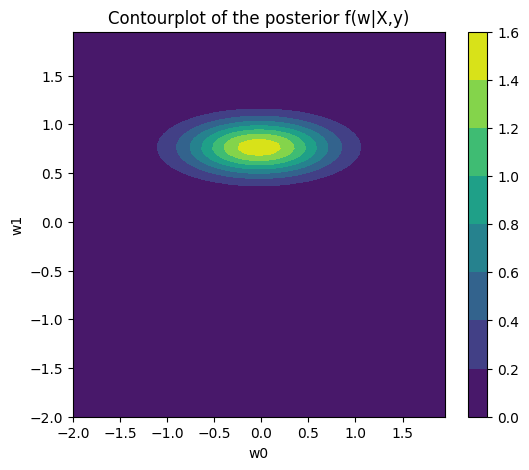

In [9]:
from scipy.stats import multivariate_normal
x12, y12 = np.mgrid[-2:2:.05, -2:2:.05]
pos = np.empty(x12.shape + (2,))
pos[:, :, 0] = x12; pos[:, :, 1] = y12
rv = multivariate_normal(w_bar.reshape(-1), A_inv)


fig, ax = plt.subplots(figsize=(6, 5))
h = plt.contourf(x12, y12, rv.pdf(pos))
fig.colorbar(h)
ax.set_ylabel("w1")
ax.set_xlabel("w0")
plt.title("Contourplot of the posterior f(w|X,y)")

## Predictive Posterior Distribution

Normally we're interested to make predictions. In the Bayesian setting we can formulate a predictive distribution for a new point $x_*$. $f_*$ represents the prediction at the point $x_*$ which we see or measure.

$$
\begin{equation}
\begin{split}
f(\mathrm{f}_* \mid x_*, X, \mathrm{y}) 
    &= \int f(\mathrm{f}_* \mid x_{*},X,\mathrm{y}, \mathrm{w})
        f(\mathrm{w} \mid X, \mathrm{y}) d\mathrm{w} \\
    &= \int f(\mathrm{f}_* \mid x_{*},\mathrm{w})
        f(\mathrm{w} \mid X, \mathrm{y}) d\mathrm{w} \\   
\end{split}
\end{equation}
$$

where:

$$
f(\mathrm{f}_* \mid x_{*},\mathrm{w}) = \mathcal{N}(\mathrm{f}_* \mid \mathrm{w}^Tx_*,\sigma_n) \\
\text{and} \\
f(\mathrm{w} \mid \mathrm{y}, X) = \mathcal{N}(\bar{\mathrm{w}},A^{-1})
$$

 The posterior distribution of the parameters $f(\mathrm{w} \mid \mathrm{y}, X)$ has been derived above.  

In the integral above we need to marginalize $\mathrm{w}$. Therefore, we need to integrate over the whole  $\mathrm{w}$-space. In Bayesian inference, these types of integrals are frequent and are mostly intractable. In this case, there exists however an analytical solution.


\begin{align*}
f(\mathrm{f}_* \mid x_*, X, \mathrm{y}) 
    &= \int f(\mathrm{f}_* \mid x_{*},\mathrm{w})
        f(\mathrm{w} \mid X, \mathrm{y}) d\mathrm{w} \\ 
f(\mathrm{f}_* \mid x_*, X, \mathrm{y}) 
    &= \mathcal{N}(\frac{1}{\sigma_n^2}x_*^TA^{-1}Xy,\space x_*^TA^{-1}x_*) 
\end{align*}


In [10]:
x0_star = np.ones(100).astype(float)
x1_star = np.linspace(-5,5,100)
x_star = np.vstack((x0_star,x1_star))

In [11]:
f_mean_star = (1/np.power(sigma_n,2) *  \
               np.dot(np.dot(x_star.T,np.dot(A_inv,X)),y)).reshape(-1)
Sigma_star = np.dot(x_star.T,np.dot(A_inv,x_star))

Let's create a predictive uncertainty region: 

In [12]:
f_mean_star_lowerBound = f_mean_star - 1.96 * np.sqrt(Sigma_star.diagonal())
f_mean_star_upperBound = f_mean_star + 1.96 * np.sqrt(Sigma_star.diagonal())

In [13]:
f_mean_star_lowerBound.shape

(100,)

[None, None]

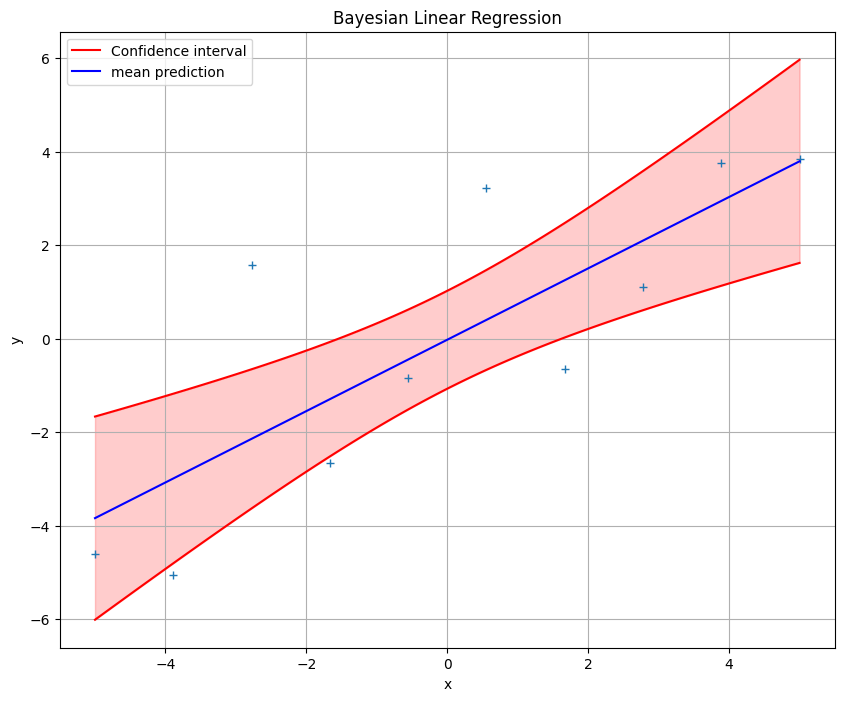

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x1,y,'+')
ax.plot(x1_star,f_mean_star_lowerBound,c='r',label='Confidence interval')
ax.plot(x1_star,f_mean_star_upperBound,c='r')
ax.plot(x1_star,f_mean_star,'b',label='mean prediction')
ax.grid()
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_title("Bayesian Linear Regression")
ax.fill_between(x1_star,f_mean_star_lowerBound, f_mean_star_upperBound,
                alpha=0.2, color='r')
ax.legend(loc=0)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=10)

## House Price Example

In [15]:
import numpy as np
import matplotlib.pylab as plt

In [16]:
# House Price Dataset
x0 = np.ones(30).astype(float)
x1 = np.array([50,55,59,61,79,81,88,90,91,97,99,105,107,110,111,112,116,117,121,123,124,125,135,141, 142,144,145,149, 150,151])
y = np.array([0.36,0.37,0.28,0.29,0.3, 0.5,0.58,0.61,0.62,0.78,0.77,0.83,0.78,0.84,0.91,0.95,1.05,0.99,0.97,0.93,0.81, 0.9,1.1, 0.98, 0.88, 1.05, 1.02, 1.1, 1.08, 1.12])
X = np.vstack((x0, x1))
print(X.shape)
print(y.shape)

(2, 30)
(30,)


Text(0.5, 1.0, 'House prices in Zurich')

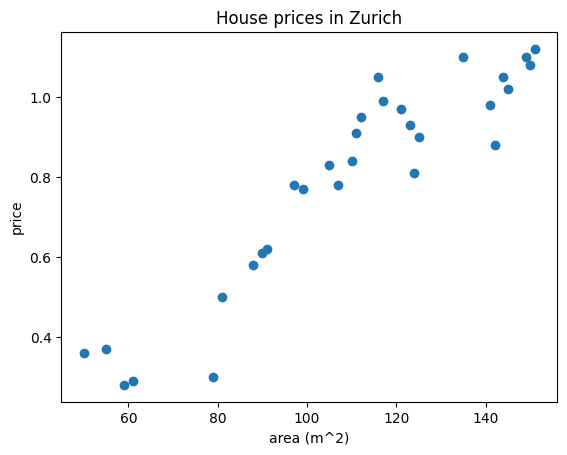

In [17]:
plt.scatter(x1,y)
plt.ylabel("price")
plt.xlabel("area (m^2)")
plt.title("House prices in Zurich")

In [18]:
# Noise of prior distribution
Sigma_p = np.eye(X.shape[0])*10
sigma_n = 0.3

Text(0.5, 1.0, 'Contourplot of Prior p(w)')

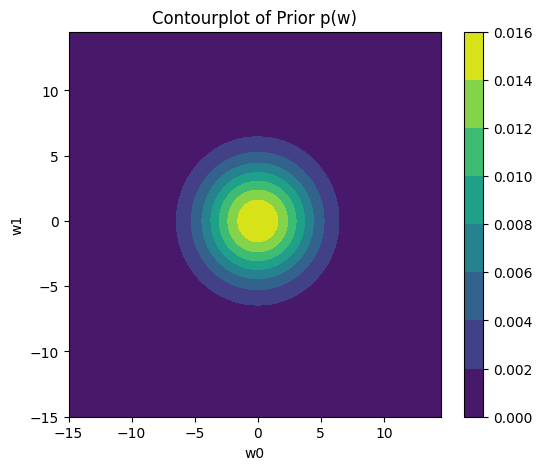

In [19]:
from scipy.stats import multivariate_normal
x12, y12 = np.mgrid[-15:15:.5, -15:15:.5]
pos = np.empty(x12.shape + (2,))
pos[:, :, 0] = x12; pos[:, :, 1] = y12
rv = multivariate_normal([0,0], Sigma_p)

fig, ax = plt.subplots(figsize=(6, 5))
h = ax.contourf(x12, y12, rv.pdf(pos))
fig.colorbar(h)
ax.set_ylabel("w1")
ax.set_xlabel("w0")
plt.title("Contourplot of Prior p(w)")

In [20]:
A = 1/np.power(sigma_n,2) * np.dot(X,X.T) + np.linalg.inv(Sigma_p)
A_inv = np.linalg.inv(A)
b = 1/np.power(sigma_n,2) * np.dot(X,y)
w_bar = np.dot(A_inv,b)

Text(0.5, 1.0, 'Contourplot of the posterior f(w|X,y)')

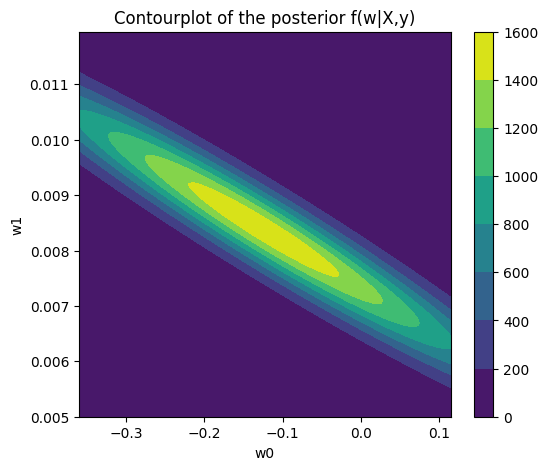

In [21]:
from scipy.stats import multivariate_normal
x12, y12 = np.mgrid[-0.36:0.12:.005, 0.005:0.012:.00005]
pos = np.empty(x12.shape + (2,))
pos[:, :, 0] = x12; pos[:, :, 1] = y12
rv = multivariate_normal(w_bar.reshape(-1), A_inv)


fig, ax = plt.subplots(figsize=(6, 5))
h = plt.contourf(x12, y12, rv.pdf(pos))
fig.colorbar(h)
ax.set_ylabel("w1")
ax.set_xlabel("w0")
plt.title("Contourplot of the posterior f(w|X,y)")

In [22]:
x0_star = np.ones(100).astype(float)
x1_star = np.linspace(40,160,100)
x_star = np.vstack((x0_star,x1_star))

In [23]:
f_mean_star = (1/np.power(sigma_n,2) *  \
               np.dot(np.dot(x_star.T,np.dot(A_inv,X)),y)).reshape(-1)
Sigma_star = np.dot(x_star.T,np.dot(A_inv,x_star))

Let's create a 95% predictive region: 

In [24]:
f_mean_star_lowerBound = f_mean_star - 1.96 * np.sqrt(Sigma_star.diagonal())
f_mean_star_upperBound = f_mean_star + 1.96 * np.sqrt(Sigma_star.diagonal())

In [25]:
f_mean_star_lowerBound.shape

(100,)

[None, None]

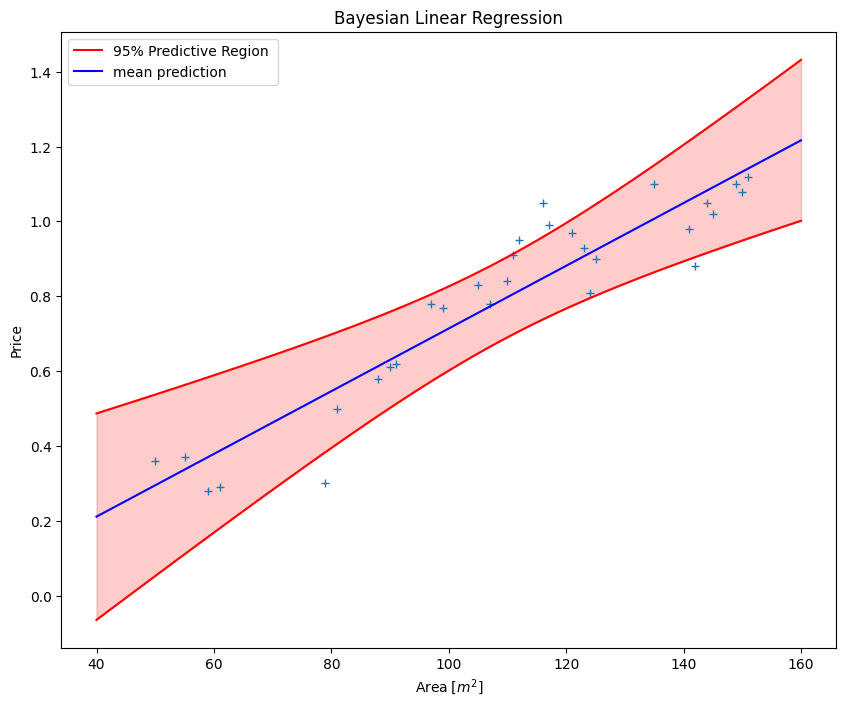

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x1,y,'+')
ax.plot(x1_star,f_mean_star_lowerBound,c='r',label='95% Predictive Region ')
ax.plot(x1_star,f_mean_star_upperBound,c='r')
ax.plot(x1_star,f_mean_star,'b',label='mean prediction')
ax.set_ylabel("Price")
ax.set_xlabel(r'$\text{Area}\; [m^2]$')
ax.set_title("Bayesian Linear Regression")
ax.fill_between(x1_star,f_mean_star_lowerBound, f_mean_star_upperBound,
                alpha=0.2, color='r')
ax.legend(loc=0)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=10)